#PROTOTYPE PENELITIAN

Nama : Mochammad Hazmi Cokro Mandiri \
NIM : 201710370311240

Deskripsi Dataset : 

Dataset berisi sekumpulan gambar retina yang diambil dengan menggunakan fotografi fundus dalam berbagai kondisi pencitraan.
Terdapat 5 kelas dengan skala 0 - 4 antara lain :

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR

Total Gambar = 3662 file

# Library

In [ ]:
import os
import shutil
import pandas as pd
import numpy as np
import random
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import load_img
import os
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

2  CPU cores


#Exploratory Data Analysis (EDA)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/201710370311240 - Hazmi Cokro'

/content/drive/MyDrive/201710370311240 - Hazmi Cokro


In [ ]:
def load_data():
    train = pd.read_csv('train.csv')
    train_dir = os.path.join('/content/drive/MyDrive/201710370311240 - Hazmi Cokro/[Copy] Dataset APTOS/')
    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    train['diagnosis'] = train['diagnosis'].astype(str)
    return train

In [ ]:
df_train = load_data()
df_train.head(10)

,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/201710370311240 - Hazmi...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/201710370311240 - Hazmi...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/201710370311240 - Hazmi...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/201710370311240 - Hazmi...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/201710370311240 - Hazmi...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/201710370311240 - Hazmi...,0083ee8054ee.png
6,0097f532ac9f,0,/content/drive/MyDrive/201710370311240 - Hazmi...,0097f532ac9f.png
7,00a8624548a9,2,/content/drive/MyDrive/201710370311240 - Hazmi...,00a8624548a9.png
8,00b74780d31d,2,/content/drive/MyDrive/201710370311240 - Hazmi...,00b74780d31d.png
9,00cb6555d108,1,/content/drive/MyDrive/201710370311240 - Hazmi...,00cb6555d108.png


#Visualisasi Gambar Tiap Kelas

###[2.1] Original Version

In [ ]:
IMG_SIZE = 224

def visualisasi_gambar(df,pts_per_class):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Contoh Data Penyakit")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE,IMG_SIZE)))
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

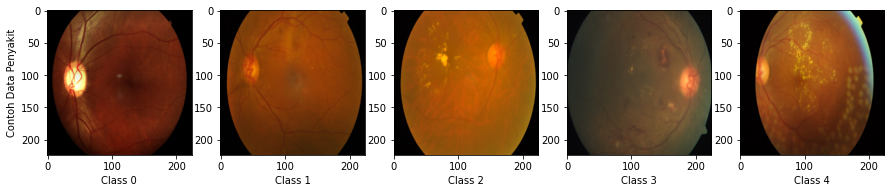

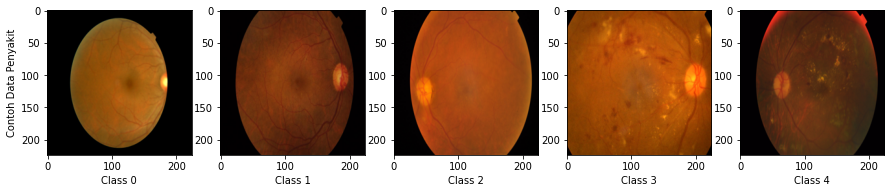

In [ ]:
visualisasi_gambar(df_train,2)

###[2.2] Gaussian Blur - 10 Version

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

In [ ]:
def visualisasi_gambar_GB(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Hasil Gaussian Blur")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = crop_image_from_gray(img)
            img = cv2.resize(img, (224, 224))
            img = cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

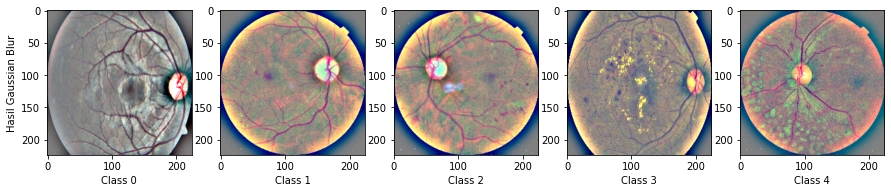

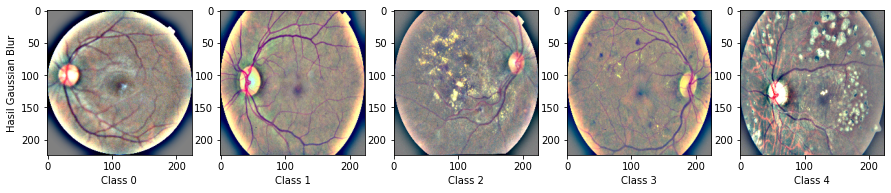

In [ ]:
visualisasi_gambar_GB(df_train,2,sigmaX = 10)

###[2.2] Gaussian Blur - 30 Version + CROP CIRCLE / Ben Graham Preprocessing

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): 
            return img 
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop(img, sigmaX):   
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

In [ ]:
def visualisasi_gambar_GB(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Hasil Gaussian Blur")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

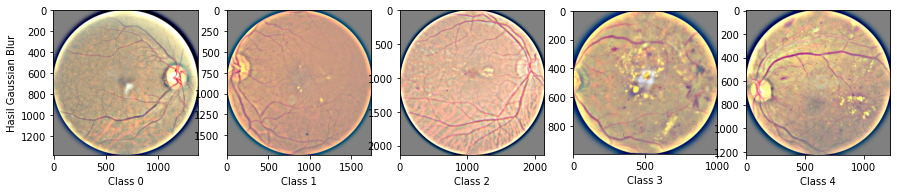

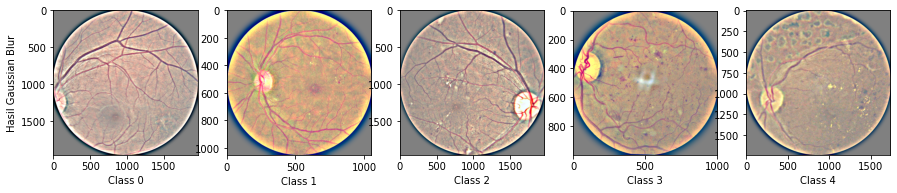

In [ ]:
visualisasi_gambar_GB(df_train,2,sigmaX = 30)

###[2.3] Usuyama Preprocessing

In [ ]:
def estimate_radius(img):
    mx = img[img.shape[0] // 2,:,:].sum(1)
    rx = (mx > mx.mean() / 10).sum() / 2
    my = img[:,img.shape[1] // 2,:].sum(1)
    ry = (my > my.mean() / 10).sum() / 2
    return (ry, rx)

def subtract_gaussian_blur(img):
    gb_img = cv2.GaussianBlur(img, (0, 0), 10)
    return cv2.addWeighted(img, 4, gb_img, -4, 128)

def remove_outer_circle(a, p, r):
    b = np.zeros(a.shape, dtype=np.uint8)
    cv2.circle(b, (a.shape[1] // 2, a.shape[0] // 2), int(r * p), (1, 1, 1), -1, 8, 0)
    return a * b + 128 * (1 - b)

def crop_img(img, h, w):
        h_margin = (img.shape[0] - h) // 2 if img.shape[0] > h else 0
        w_margin = (img.shape[1] - w) // 2 if img.shape[1] > w else 0
        crop_img = img[h_margin:h + h_margin,w_margin:w + w_margin,:]
        return crop_img

def place_in_square(img, r, h, w):
    new_img = np.zeros((2 * r, 2 * r, 3), dtype=np.uint8)
    new_img += 128
    new_img[r - h // 2:r - h // 2 + img.shape[0], r - w // 2:r - w // 2 + img.shape[1]] = img
    return new_img

In [ ]:
def visualisasi_gambar_usuyama(df,pts_per_class,scale):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Hasil Usuyama")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            ry, rx = estimate_radius(img)

            resize_scale = scale / max(rx, ry)
            w = min(int(rx * resize_scale * 2), scale * 2)
            h = min(int(ry * resize_scale * 2), scale * 2)

            img = cv2.resize(img, (0,0), fx=resize_scale, fy=resize_scale)
            
            img = crop_img(img, h, w)
            
            img = subtract_gaussian_blur(img)
            img = remove_outer_circle(img, 0.9, scale)
            img = place_in_square(img, scale, h, w)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

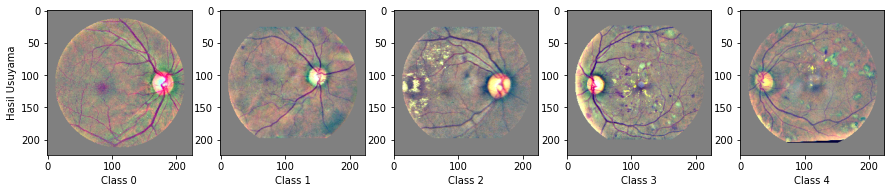

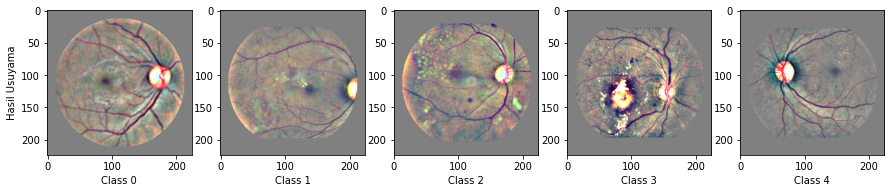

In [ ]:
visualisasi_gambar_usuyama(df_train,2,scale = 112)